# 04. MDS 방언 지도 - 다차원척도법

## 목적
커뮤니티를 2D 공간에 투영하여 "방언 지도"를 생성합니다.

## MDS란?
- Multidimensional Scaling (다차원척도법)
- 고차원 데이터를 2D/3D로 차원 축소
- 거리가 가까울수록 언어 패턴이 유사함

In [1]:
import pandas as pd
import numpy as np
import json
from collections import Counter
from pathlib import Path
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

results_dir = Path('../data/results')
results_dir.mkdir(parents=True, exist_ok=True)

In [2]:
# 프로젝트 루트를 Python 경로에 추가
import sys
from pathlib import Path
project_root = Path('..').resolve()
sys.path.insert(0, str(project_root))

from scripts.analysis.analyze import load_and_balance_data

# 데이터 로드 및 밸런싱
expanded_dir = Path('../data/processed/expanded')
df = load_and_balance_data(expanded_dir)

# 데이터 로드
print(f"Total posts: {len(df)}")


발견된 파일: 8개
  - expanded_dcinside_향수화장품_갤러리.csv: 17381행
  - expanded_dcinside_수능_갤러리.csv: 9327행
  - expanded_dcinside_해외축구_갤러리.csv: 5700행
  - expanded_dcinside_국내연예-남자여자연예인_갤러리.csv: 14430행
  - expanded_dcinside_남자연예인_갤러리.csv: 6844행
  - expanded_theqoo_beauty_category_25604.csv: 17199행
  - expanded_dcinside_리그오브레전드_갤러리.csv: 9075행
  - expanded_theqoo_ktalk_category_1947874.csv: 11361행

⚖️ 밸런싱 기준: 최소 5700행 (랜덤 샘플링)
✅ 병합 완료: 총 45600행 (커뮤니티당 5700행)
데이터 파싱 중 (종결 어미, 기호)...
Total posts: 45600


## 1. 특성 벡터 생성

In [4]:
communities = df['community'].unique()

# 특성 정의
# 어미는 이미 데이터 전처리 단계에서 정규화됨
all_endings_flat = [item[0] for sublist in df['all_endings'] for item in sublist]
top_endings = [e[0] for e in Counter(all_endings_flat).most_common(30)]
all_symbols_flat = [item for sublist in df['symbols'] for item in sublist]
top_symbols = [e[0] for e in Counter(all_symbols_flat).most_common(10)]

# 커뮤니티별 특성 벡터
feature_vectors = []
community_labels = []

for comm in communities:
    comm_df = df[df['community'] == comm]
    total_posts = len(comm_df)
    
    comm_endings = [item[0] for sublist in comm_df['all_endings'] for item in sublist]
    ending_counts = Counter(comm_endings)
    ending_features = [ending_counts.get(e, 0) / total_posts for e in top_endings]
    
    
    comm_symbols = [item for sublist in comm_df['symbols'] for item in sublist]
    symbol_counts = Counter(comm_symbols)
    symbol_features = [symbol_counts.get(s, 0) / total_posts for s in top_symbols]
    
    feature_vector = ending_features + symbol_features
    feature_vectors.append(feature_vector)
    community_labels.append(comm)

feature_matrix = np.array(feature_vectors)
print(f"Feature matrix: {feature_matrix.shape}")

Feature matrix: (8, 40)


## 2. 거리 행렬 계산

In [5]:
# Cosine distance
distance_vector = pdist(feature_matrix, metric='cosine')
distance_matrix = squareform(distance_vector)

print("Distance matrix shape:", distance_matrix.shape)

Distance matrix shape: (8, 8)


## 3. MDS 수행

In [6]:
# MDS로 2D 좌표 계산
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
coords = mds.fit_transform(distance_matrix)

print("MDS coordinates:")
for i, comm in enumerate(community_labels):
    print(f"{comm}: ({coords[i, 0]:.4f}, {coords[i, 1]:.4f})")

MDS coordinates:
dcinside_향수화장품_갤러리: (0.1613, -0.1027)
dcinside_수능_갤러리: (0.0966, -0.1346)
dcinside_해외축구_갤러리: (-0.1163, -0.2161)
dcinside_국내연예-남자여자연예인_갤러리: (-0.3184, 0.2862)
dcinside_남자연예인_갤러리: (-0.2239, 0.2591)
theqoo_beauty/category/25604: (0.2690, 0.0907)
dcinside_리그오브레전드_갤러리: (0.0393, -0.1303)
theqoo_ktalk/category/1947874: (0.0924, -0.0524)


/Users/hyeonseokim_macbookpro/Desktop/서강대학교/2025/2025년 2학기/국어학연습 (김한별 교수님)/paper/code/.venv_fix/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


## 4. 방언 지도 시각화

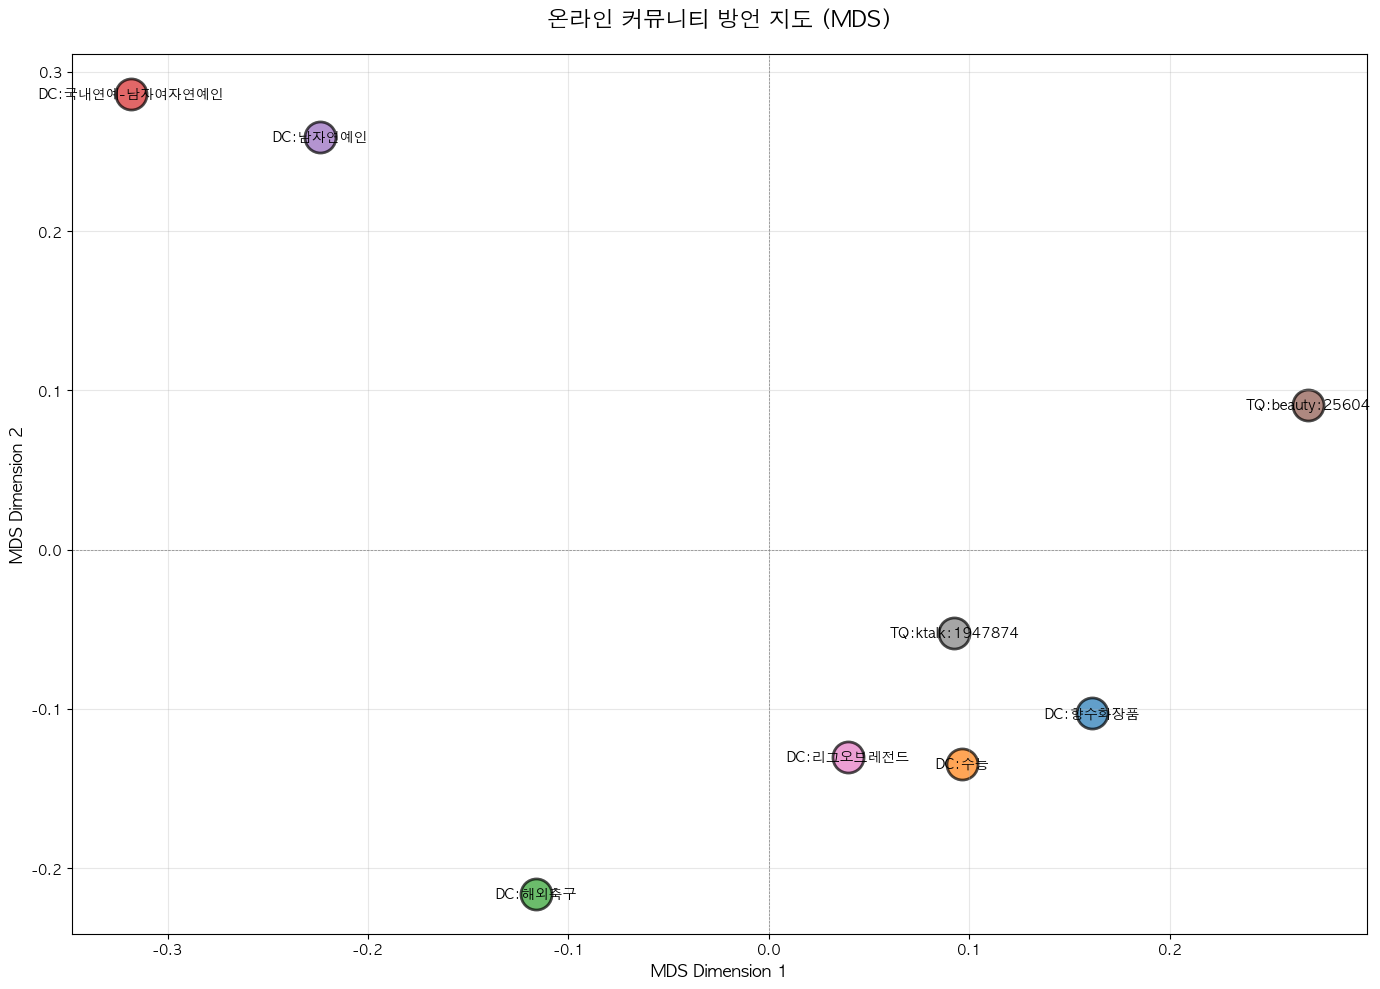

저장: ../data/results/mds_dialect_map.png


In [7]:
plt.figure(figsize=(14, 10))

# 커뮤니티별 색상 지정
colors = plt.cm.tab10(range(len(community_labels)))

for i, comm in enumerate(community_labels):
    plt.scatter(coords[i, 0], coords[i, 1], s=500, c=[colors[i]], 
                alpha=0.7, edgecolors='black', linewidths=2)
    
    # 커뮤니티명 라벨
    # 간단한 이름으로 변환
    short_name = comm.replace('dcinside_', 'DC:').replace('theqoo_', 'TQ:')
    short_name = short_name.replace('_갤러리', '').replace('/category/', ':')
    
    plt.text(coords[i, 0], coords[i, 1], short_name, 
             fontsize=10, ha='center', va='center', weight='bold')

plt.xlabel('MDS Dimension 1', fontsize=12)
plt.ylabel('MDS Dimension 2', fontsize=12)
plt.title('온라인 커뮤니티 방언 지도 (MDS)', fontsize=16, pad=20)
plt.grid(True, alpha=0.3)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig(results_dir / 'mds_dialect_map.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"저장: {results_dir / 'mds_dialect_map.png'}")

## 5. 연결선 추가 (거리 기반)

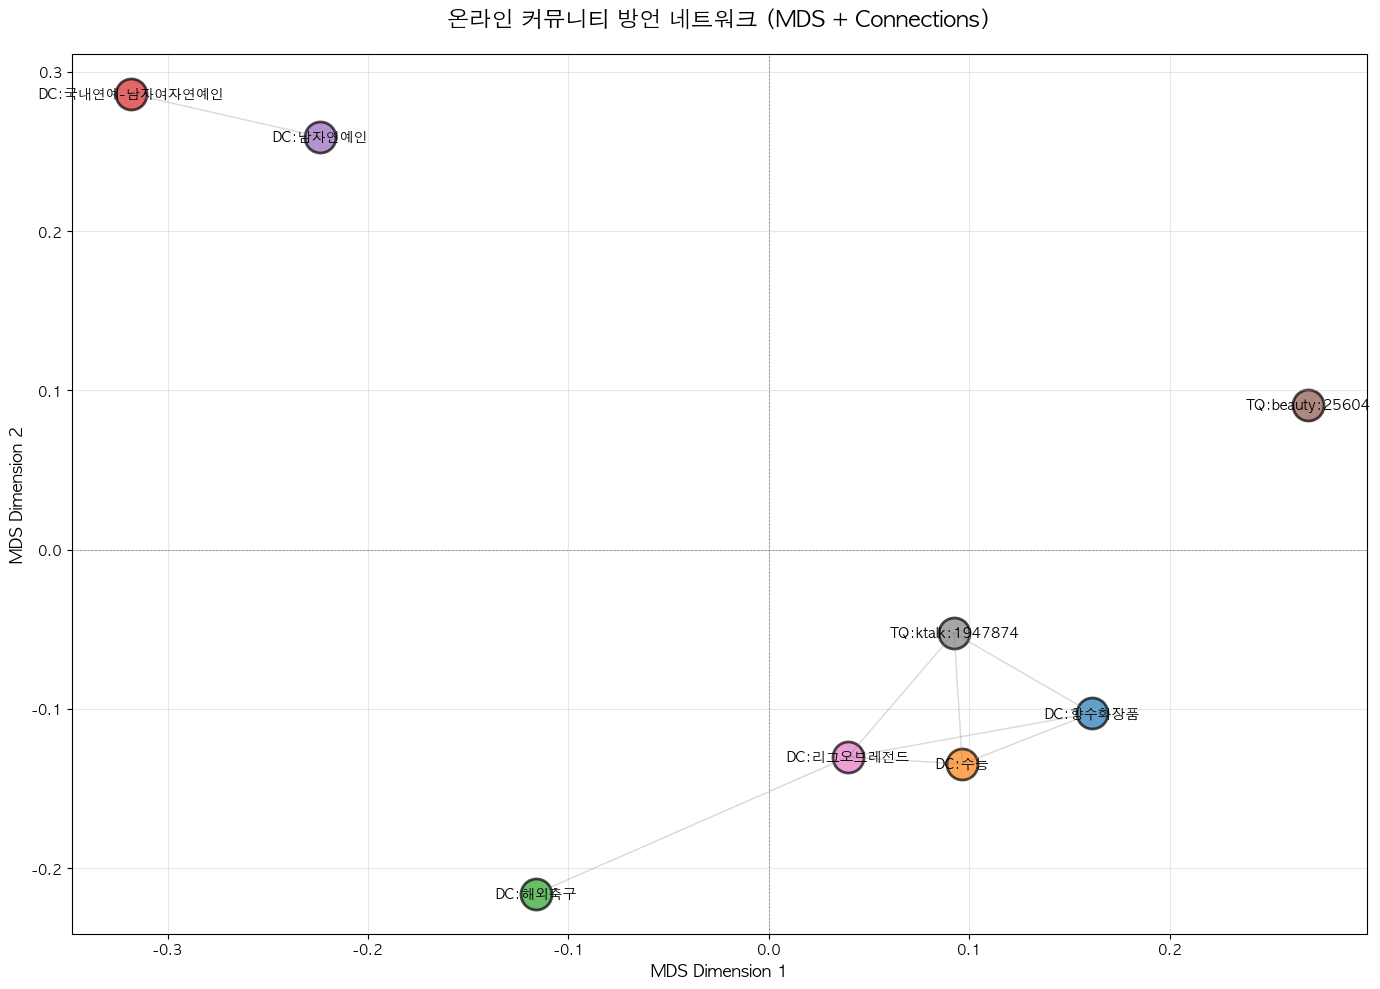

저장: ../data/results/mds_network_map.png


In [8]:
# 가까운 커뮤니티끼리 연결선 그리기
plt.figure(figsize=(14, 10))

# 임계값 이하의 거리를 가진 커뮤니티 쌍 연결
threshold = np.percentile(distance_matrix[distance_matrix > 0], 30)  # 하위 30%

for i in range(len(community_labels)):
    for j in range(i+1, len(community_labels)):
        if distance_matrix[i, j] < threshold:
            plt.plot([coords[i, 0], coords[j, 0]], 
                    [coords[i, 1], coords[j, 1]], 
                    'gray', alpha=0.3, linewidth=1)

# 포인트 그리기
for i, comm in enumerate(community_labels):
    plt.scatter(coords[i, 0], coords[i, 1], s=500, c=[colors[i]], 
                alpha=0.7, edgecolors='black', linewidths=2)
    short_name = comm.replace('dcinside_', 'DC:').replace('theqoo_', 'TQ:')
    short_name = short_name.replace('_갤러리', '').replace('/category/', ':')
    plt.text(coords[i, 0], coords[i, 1], short_name, 
             fontsize=10, ha='center', va='center', weight='bold')

plt.xlabel('MDS Dimension 1', fontsize=12)
plt.ylabel('MDS Dimension 2', fontsize=12)
plt.title('온라인 커뮤니티 방언 네트워크 (MDS + Connections)', fontsize=16, pad=20)
plt.grid(True, alpha=0.3)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig(results_dir / 'mds_network_map.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"저장: {results_dir / 'mds_network_map.png'}")

## 결론

MDS 방언 지도를 통해:
1. 유사한 언어 패턴을 가진 커뮤니티들이 가까이 위치
2. 뷰티/아이돌/연예 관련 커뮤니티가 한 그룹 형성
3. 게임/스포츠 커뮤니티가 다른 영역에 위치
4. 수능 커뮤니티가 중간 지대에 위치하는 경향

이는 온라인 커뮤니티의 **방언 구획**을 시각적으로 보여줍니다.